## Пошаговая отладка процесса оптимизации

Этот ноутбук предназначен для детального анализа работы оптимизатора. Мы будем запускать оптимизацию и на каждой итерации сохранять значения всех ключевых компонентов функции потерь, чтобы понять, как они влияют на итоговое решение.


In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# Настройка импортов
# Добавляем путь к корневой директории проекта, чтобы можно было импортировать из src
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator


### 2. Настройка и запуск оптимизации с колбэком

Мы определим `callback` функцию, которая будет вызываться `scipy.minimize` после каждой итерации. Эта функция будет использовать наш новый метод `calculate_loss_components` для сбора данных.


### 3. Формула и веса для оптимизации

#### Полная функция потерь (Total Loss)
Цель оптимизации — минимизировать следующую функцию:

$ L_{total} = w_{distance} \cdot L_{distance} + w_{velocity} \cdot L_{velocity} + w_{repulsion} \cdot L_{repulsion} - w_{time} \cdot L_{time} $

где:
- $L_{distance}$ — потери, основанные на **расстоянии** между "внуками". Отвечают за то, чтобы они просто были близко.
- $L_{velocity}$ — потери, основанные на **скорости сближения**. Поощряют "внуков" двигаться навстречу друг другу.
- $L_{repulsion}$ — потери отталкивания. Заставляют центры пар держаться на расстоянии.
- $L_{time}$ — бонус за время. Поощряет рост "дерева".

#### Компоненты потерь
1.  **Потери расстояния ($L_{distance}$)**:
    - Для каждого "внука" $i$ агрегируются квадраты расстояний до кандидатов $j$: 
      $L_{dist, i} = \text{softmin}(\|v_i - v_{j1}\|^2, \|v_i - v_{j2}\|^2, ...)$
    - Итоговая потеря: $L_{distance} = \sum_i L_{dist, i}$

2.  **Потери скорости ($L_{velocity}$)**:
    - Агрегируются скалярные произведения относительной позиции на относительную скорость:
      $L_{vel, i} = \text{softmin}((v_i - v_{j1}) \cdot (\dot{v}_i - \dot{v}_{j1}), ...)$
    - Итоговая потеря: $L_{velocity} = \sum_i L_{vel, i}$

3.  **Потери отталкивания ($L_{repulsion}$)**:
    - Сумма обратных расстояний между центрами масс всех пар:
      $L_{repulsion} = \sum_{a, b: a \neq b} \frac{1}{\|\text{mean}_a - \text{mean}_b\|}$

4.  **Бонус за время ($L_{time}$)**:
    - p-норма векторов `dt`:
      $L_{time} = \left( \sum_k |dt_k|^p \right)^{1/p}$
    - **`p_norm < 1`** приоритезирует рост самых маленьких `dt`.



### 1. Инициализация системы


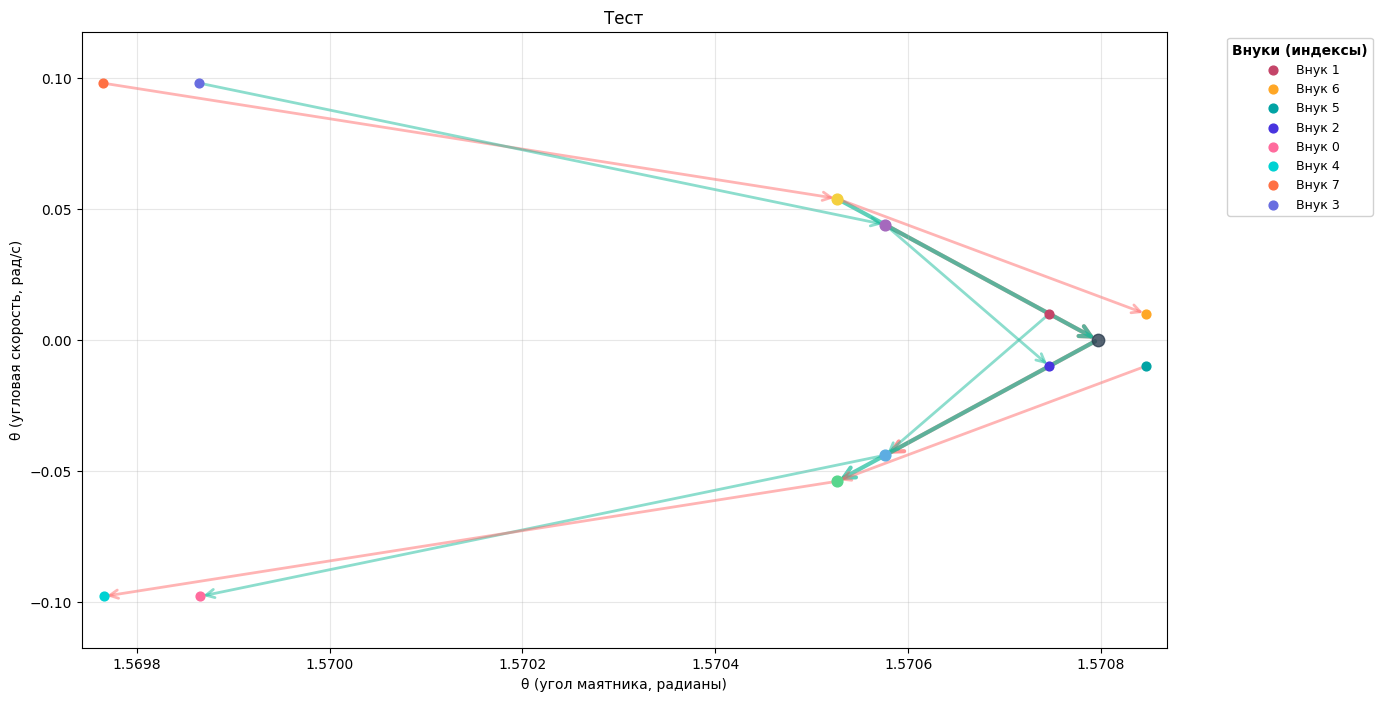

In [2]:
pendulum = PendulumSystem()
config = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.01,
    figure_size=(14, 8),
    dt_grandchildren_factor=1,
    show_debug=False
)

tree = SporeTree(pendulum, config)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

evaluator = TreeEvaluator(tree)

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")

In [3]:
# Список для хранения истории
history = []

# --- Веса и параметры для функции потерь ---

# w_distance: Вес для L_distance.
# Отвечает за минимизацию расстояния между "внуками".
w_distance = 100

# w_velocity: Вес для L_velocity.
# Поощряет сближение (отрицательное скалярное произведение).
w_velocity = 0.0

# w_repulsion: Вес для L_repulsion.
w_repulsion = 0

# w_time: Вес для бонуса за время L_time.
w_time = 0.1

# p_norm: Параметр p-нормы для L_time.
p_norm = 0.001

# alpha: Параметр "мягкости" для softmin.
softmin_alpha = 30


def objective_for_minimize(dt_all):
    """Целевая функция, которая будет минимизироваться."""
    return evaluator.dynamic_loss(
        dt_all, 
        alpha=softmin_alpha, 
        w_distance=w_distance,
        w_velocity=w_velocity,
        w_repulsion=w_repulsion,
        w_time=w_time,
        p_norm=p_norm
    )

def callback_function(current_dt):
    """Эта функция вызывается на каждой итерации для сбора и вывода данных."""
    iteration_number = len(history)
    
    # Получаем "сырые" компоненты
    components = evaluator.calculate_loss_components(
        current_dt, 
        alpha=softmin_alpha,
        p_norm=p_norm
    )
    
    # Собираем взвешенные компоненты для логирования
    log_entry = {
        'total_loss': (
            w_distance * components['distance_loss'] + 
            w_velocity * components['velocity_loss'] +
            w_repulsion * components['repulsion_loss'] - 
            w_time * components['time_bonus']
        ),
        'distance_loss': w_distance * components['distance_loss'],
        'velocity_loss': w_velocity * components['velocity_loss'],
        'repulsion_loss': w_repulsion * components['repulsion_loss'],
        'time_bonus': w_time * components['time_bonus'],
        'sum_abs_dt': components['sum_abs_dt']
    }
    history.append(log_entry)
    
    print(f"Итерация {iteration_number}: Total={log_entry['total_loss']:.3f} (Dist={log_entry['distance_loss']:.3f}, Vel={log_entry['velocity_loss']:.3f}, Repul={log_entry['repulsion_loss']:.3f}, TimeBonus={log_entry['time_bonus']:.3f})")

# Начальное приближение
dt = 0.01
init_guess = np.hstack((np.ones(4) * dt, np.ones(8) * dt * config.dt_grandchildren_factor))
bounds = [(0.001, 0.2)] * 12

print("--- Начало оптимизации ---")
result = minimize(
    objective_for_minimize, 
    init_guess, 
    method='SLSQP',
    bounds=bounds, 
    callback=callback_function,
    options={'maxiter': 20, 'disp': True, 'eps': 1e-6, 'ftol': 1e-10}
)
print("--- Оптимизация завершена ---")


--- Начало оптимизации ---
Итерация 0: Total=0.510 (Dist=1.704, Vel=-0.000, Repul=0.000, TimeBonus=1.194)
Итерация 1: Total=-48.698 (Dist=-47.506, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 2: Total=-47.361 (Dist=-46.169, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 3: Total=-26.247 (Dist=-25.054, Vel=-0.000, Repul=0.000, TimeBonus=1.193)
Итерация 4: Total=-48.768 (Dist=-47.576, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 5: Total=-48.881 (Dist=-47.690, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 6: Total=-48.803 (Dist=-47.611, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 7: Total=-48.863 (Dist=-47.671, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 8: Total=-48.875 (Dist=-47.683, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 9: Total=-48.884 (Dist=-47.692, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 10: Total=-48.884 (Dist=-47.692, Vel=-0.000, Repul=0.000, TimeBonus=1.192)
Итерация 11: Total=-48.884 (Dist=-47.692, Vel=-0.000, Repul=0.0

C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


### 3. Анализ результатов


### 4. Визуализация финального состояния


Финальные параметры dt: [0.001    0.001    0.001    0.001    0.001    0.001081 0.001081 0.001
 0.001    0.001553 0.001552 0.001   ]


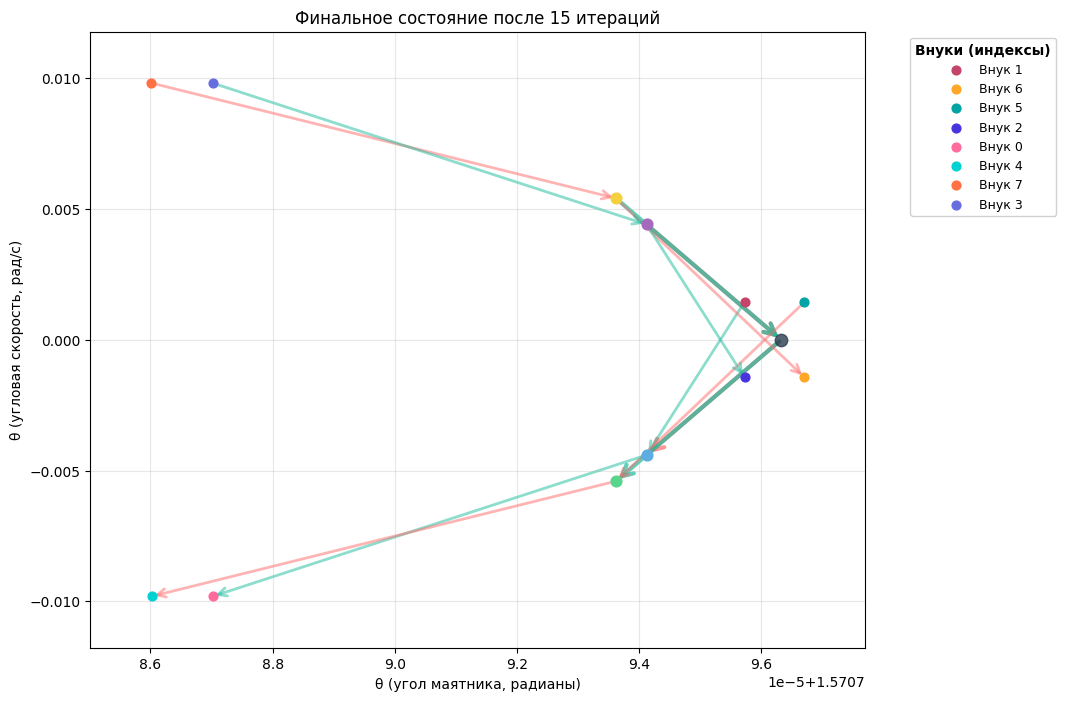

In [4]:
print("Финальные параметры dt:", np.round(result.x, 6))
# Обновляем дерево с финальными параметрами для визуализации
evaluator._build_if_needed(result.x)

# Настройки matplotlib для лучшего качества
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Используем увеличенный размер полотна для лучшей визуализации
visualize_spore_tree(tree, 
                    title=f"Финальное состояние после {len(history)} итераций",
                    figsize=(10, 8))


История изменения компонентов функции потерь:


,total_loss,distance_loss,velocity_loss,time_bonus,repulsion_loss,sum_abs_dt
0,0.510414,1.704263,-0.0,1.193850,0.0,0.808000
1,-48.698366,-47.506413,-0.0,1.191953,0.0,0.019560
2,-47.361164,-46.169183,-0.0,1.191980,0.0,0.022284
3,-26.246721,-25.054172,-0.0,1.192549,0.0,0.128729
4,-48.767736,-47.575770,-0.0,1.191965,0.0,0.017371
5,-48.881390,-47.689651,-0.0,1.191739,0.0,0.012000
6,-48.803205,-47.611208,-0.0,1.191997,0.0,0.018202
7,-48.862676,-47.670731,-0.0,1.191945,0.0,0.015655
8,-48.874571,-47.682623,-0.0,1.191948,0.0,0.015066
9,-48.884013,-47.692160,-0.0,1.191853,0.0,0.013434


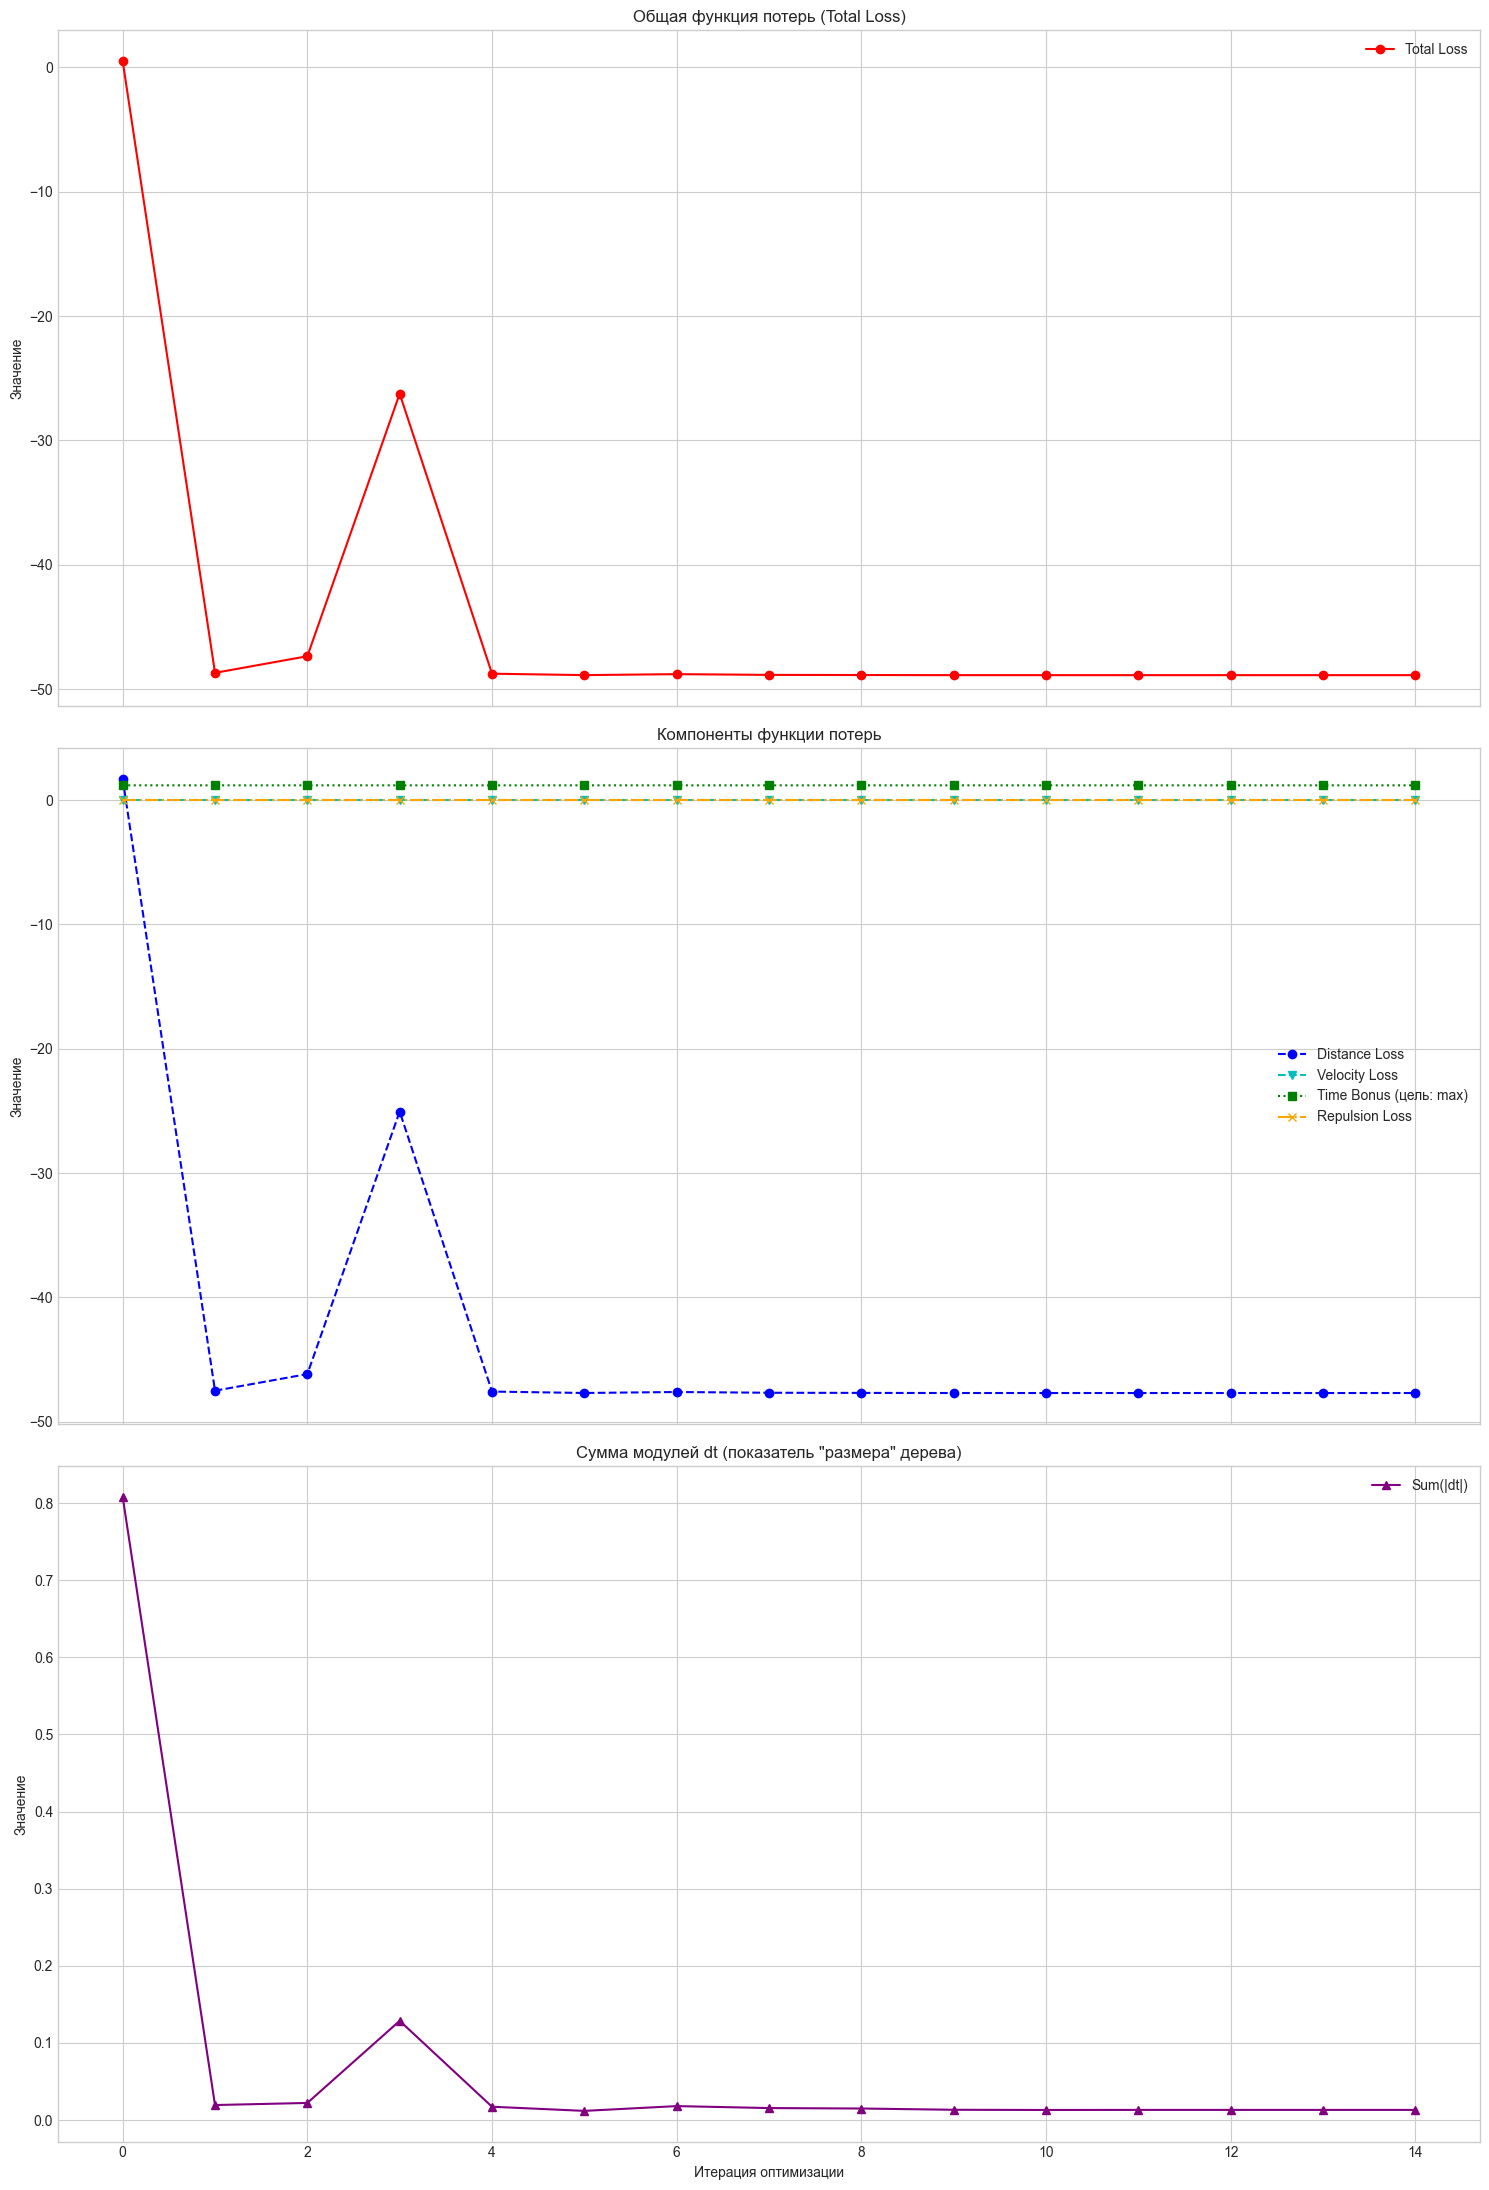

In [5]:
# Преобразуем историю в DataFrame для удобства
history_df = pd.DataFrame(history)

print("История изменения компонентов функции потерь:")
display(history_df[['total_loss', 'distance_loss', 'velocity_loss', 'time_bonus', 'repulsion_loss', 'sum_abs_dt']])

# Визуализация
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(15, 22), sharex=True)

# График общей потери
ax[0].plot(history_df.index, history_df['total_loss'], marker='o', linestyle='-', label='Total Loss', color='r')
ax[0].set_title('Общая функция потерь (Total Loss)')
ax[0].set_ylabel('Значение')
ax[0].legend()

# График компонентов
ax[1].plot(history_df.index, history_df['distance_loss'], marker='o', linestyle='--', label='Distance Loss', color='b')
ax[1].plot(history_df.index, history_df['velocity_loss'], marker='v', linestyle='--', label='Velocity Loss', color='c')
ax[1].plot(history_df.index, history_df['time_bonus'], marker='s', linestyle=':', label='Time Bonus (цель: max)', color='g')
ax[1].plot(history_df.index, history_df['repulsion_loss'], marker='x', linestyle='-.', label='Repulsion Loss', color='orange')
ax[1].set_title('Компоненты функции потерь')
ax[1].set_ylabel('Значение')
ax[1].legend()

# График суммы модулей dt
ax[2].plot(history_df.index, history_df['sum_abs_dt'], marker='^', linestyle='-', label='Sum(|dt|)', color='purple')
ax[2].set_title('Сумма модулей dt (показатель "размера" дерева)')
ax[2].set_xlabel('Итерация оптимизации')
ax[2].set_ylabel('Значение')
ax[2].legend()

plt.tight_layout()
plt.show()
